# Seasonal forecast download and plot for one coordinate

### About

This notebook is based on "Seasonal Forecast Anomalies": https://ecmwf-projects.github.io/copernicus-training-c3s/sf-anomalies.html
It was mainly modified to use daily resolution instead of monthly.
It provides a practical introduction to calculating seasonal forecast with data from the Copernicus Climate Change Service (C3S). C3S seasonal forecast products are based on data from several state-of-the-art seasonal prediction systems. In this tutorial we shall focus on the [ECMWF SEAS5 model](https://confluence.ecmwf.int/display/CKB/Description+of+SEAS5+C3S+contribution), which is one of the forecasting systems available through C3S.

The tutorial will demonstrate how to access real-time forecast data of total precipitation, with a forecast start date in May 2023 and 6-7 monthly lead times (up to October 2023). Hindcast data for the same start date and lead-time months in the reference period 1993 to 2016 will also be downloaded. 

The tutorial will then show how to interpolate in a coordinate for both the forecast and hindcast data. (The climate mean for the reference period will be computed and this reference mean will be subtracted from the real-time forecast data to derive monthly anomalies BORRAR?). These will be visualised as time series. Finally, 3-monthly anomalies will be calculated and visualised in an interactive plot, as a demonstration of how to reproduce similar [charts available through C3S](https://climate.copernicus.eu/charts/c3s_seasonal/).


The notebook has the following outline:
* 1 - Download data from the CDS
* 2 - Hindcast data 
* 3 - Real-time forecasts

<br>

<div class="alert alert-block alert-success">
<b>NOTE</b>: <br>
    <a href="https://cds.climate.copernicus.eu/cdsapp#!/dataset/seasonal-postprocessed-single-levels">Precomputed anomalies are also available through the CDS</a>. Note these may be slightly different due to minor differences in the way they are computed (e.g. months of constant length, 30 days)  and also due to GRIB packing discretisation. <a href="https://confluence.ecmwf.int/display/UDOC/Why+are+there+sometimes+small+negative+precipitation+accumulations+-+ecCodes+GRIB+FAQ">See here for more detials.</a></div>

Please see here the full documentation of the [C3S Seasonal Forecast Datasets](https://confluence.ecmwf.int/display/CKB/C3S+Seasonal+Forecasts%3A+datasets+documentation). This notebook introduces you to the [seasonal forecast monthly statistics](https://cds.climate.copernicus.eu/cdsapp#!/dataset/seasonal-monthly-single-levels?tab=overview) datasets on single levels (as opposed to multiple levels in the atmosphere).

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training-c3s/main?labpath=sf-anomalies.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th>
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training-c3s/blob/main/sf-anomalies.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
    <th><a href="https://colab.research.google.com/github/ecmwf-projects/copernicus-training-c3s/blob/main/sf-anomalies.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

<hr>

### Install packages

In [1]:
# Install CDS API for downloading data from the CDS
#!pip install cdsapi

In [2]:
# Install cfgrib to enable us to read GRIB format files
#!conda install -c conda-forge cfgrib -y

In [1]:
# Miscellaneous operating system interfaces
import os

# CDS API
import cdsapi

# To map GRIB files to NetCDF Common Data Model
import cfgrib

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import pandas as pd
import scipy

# Libraries for plotting and geospatial data visualisation
import matplotlib.path as mpath
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

# To work with data labels in dictionary format
from collections import OrderedDict

# Date and time related libraries
from dateutil.relativedelta import relativedelta
from calendar import monthrange
import datetime

# Interactive HTML widgets
import ipywidgets as widgets

# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()

<hr>

In [2]:
## 1. Request data from the CDS programmatically with the CDS API

The first step is to request data from the Climate Data Store programmatically with the help of the CDS API. Let us make use of the option to manually set the CDS API credentials. First, you have to define two variables: `URL` and `KEY` which build together your CDS API key. Below, you have to replace the `#########` with your personal CDS key. Please find [here](https://cds.climate.copernicus.eu/api-how-to) your personal CDS key.

In [18]:
URL = 'https://cds.climate.copernicus.eu/api/v2'
KEY = '5596:e5a0ace8-18ac-417c-96a5-ecb447a7eb20'
# Define the coordinates to interpolate to
interp_latitude = 42.3
interp_longitude = 2.25
variable_name = '2m_temperature'
var_short = 't2m'
month_num = 5
forecast_year = 2023


Here we specify a data directory in which we will download our data and all output files that we will generate:

In [4]:
DATADIR = '/home/daniel/Documents/intoDBP/input/seasonal'

The next step is then to request the seasonal forecast daily data on single levels with the help of the CDS API. 
Below, we download two separate files of the variable for six monthly lead times.
For instance to start date in May: 
                                                                                                                                                             
* **Retrospective forecasts (Hindcasts) for 1993 to 2016**
* **Forecasts for May 2023**

Seasonal forecast data are disseminated in the GRIB data format. Let us store the data in the main working directory with the names: 
* `ecmwf_seas5_1993_2016_05_hindcast_daily_tp.grib` and 
* `ecmwf_seas5_2023_05_forecast_daily_tp.grib`.

Running the code block below will download the data from the CDS as specified by the following API keywords:

> **Format**: `Grib` <br>
> **Originating centre**: `ECMWF` <br>
> **System**: `5` *this refers to SEAS5* <br>
> **Variable**: `Total precipitation` or `2m temperature` <br>
> **Product type**: `Monthly mean` *all ensemble members will be retrieved* <br>
> **Year**: `1993 to 2016` *for the hindcast* `2023` *for the forecast* <br>
> **Month**: `5` *May* <br>
> **Leadtime month**: `1 to 6` *May to October*

If you have not already done so, you will need to accept the **terms & conditions** of the data before you can download it. These can be viewed and accepted in the [CDS download page](https://cds.climate.copernicus.eu/cdsapp#!/dataset/seasonal-monthly-single-levels?tab=form) by scrolling to the end of the download form.

<div class="alert alert-block alert-success">
<b>NOTE</b>: <br>
    The API request below can be generated automatically from the <a href="https://cds.climate.copernicus.eu/cdsapp#!/dataset/seasonal-monthly-single-levels?tab=form">CDS download page</a>. At the end of the download form there is a <code>Show API request</code> icon, which allows a copy-paste of the code below.</div>

In [19]:
#hindacast 6h 1993-2003
c = cdsapi.Client(url=URL, key=KEY)

c.retrieve(
    'seasonal-original-single-levels',
    {
        'format': 'grib',
        'originating_centre': 'ecmwf',
        'system': '5',
        'variable': variable_name,
        'year': [
            '1993', '1994', '1995',
            '1996', '1997', '1998',
            '1999', '2000', '2001',
            '2002', '2003',
        ],
        'month': month_num,
        'day': '01',
        'leadtime_hour': [
            '6', '12', '18',
            '24', '30', '36',
            '42', '48', '54',
            '60', '66', '72',
            '78', '84', '90',
            '96', '102', '108',
            '114', '120', '126',
            '132', '138', '144',
            '150', '156', '162',
            '168', '174', '180',
            '186', '192', '198',
            '204', '210', '216',
            '222', '228', '234',
            '240', '246', '252',
            '258', '264', '270',
            '276', '282', '288',
            '294', '300', '306',
            '312', '318', '324',
            '330', '336', '342',
            '348', '354', '360',
            '366', '372', '378',
            '384', '390', '396',
            '402', '408', '414',
            '420', '426', '432',
            '438', '444', '450',
            '456', '462', '468',
            '474', '480', '486',
            '492', '498', '504',
            '510', '516', '522',
            '528', '534', '540',
            '546', '552', '558',
            '564', '570', '576',
            '582', '588', '594',
            '600', '606', '612',
            '618', '624', '630',
            '636', '642', '648',
            '654', '660', '666',
            '672', '678', '684',
            '690', '696', '702',
            '708', '714', '720',
            '726', '732', '738',
            '744', '750', '756',
            '762', '768', '774',
            '780', '786', '792',
            '798', '804', '810',
            '816', '822', '828',
            '834', '840', '846',
            '852', '858', '864',
            '870', '876', '882',
            '888', '894', '900',
            '906', '912', '918',
            '924', '930', '936',
            '942', '948', '954',
            '960', '966', '972',
            '978', '984', '990',
            '996', '1002', '1008',
            '1014', '1020', '1026',
            '1032', '1038', '1044',
            '1050', '1056', '1062',
            '1068', '1074', '1080',
            '1086', '1092', '1098',
            '1104', '1110', '1116',
            '1122', '1128', '1134',
            '1140', '1146', '1152',
            '1158', '1164', '1170',
            '1176', '1182', '1188',
            '1194', '1200', '1206',
            '1212', '1218', '1224',
            '1230', '1236', '1242',
            '1248', '1254', '1260',
            '1266', '1272', '1278',
            '1284', '1290', '1296',
            '1302', '1308', '1314',
            '1320', '1326', '1332',
            '1338', '1344', '1350',
            '1356', '1362', '1368',
            '1374', '1380', '1386',
            '1392', '1398', '1404',
            '1410', '1416', '1422',
            '1428', '1434', '1440',
            '1446', '1452', '1458',
            '1464', '1470', '1476',
            '1482', '1488', '1494',
            '1500', '1506', '1512',
            '1518', '1524', '1530',
            '1536', '1542', '1548',
            '1554', '1560', '1566',
            '1572', '1578', '1584',
            '1590', '1596', '1602',
            '1608', '1614', '1620',
            '1626', '1632', '1638',
            '1644', '1650', '1656',
            '1662', '1668', '1674',
            '1680', '1686', '1692',
            '1698', '1704', '1710',
            '1716', '1722', '1728',
            '1734', '1740', '1746',
            '1752', '1758', '1764',
            '1770', '1776', '1782',
            '1788', '1794', '1800',
            '1806', '1812', '1818',
            '1824', '1830', '1836',
            '1842', '1848', '1854',
            '1860', '1866', '1872',
            '1878', '1884', '1890',
            '1896', '1902', '1908',
            '1914', '1920', '1926',
            '1932', '1938', '1944',
            '1950', '1956', '1962',
            '1968', '1974', '1980',
            '1986', '1992', '1998',
            '2004', '2010', '2016',
            '2022', '2028', '2034',
            '2040', '2046', '2052',
            '2058', '2064', '2070',
            '2076', '2082', '2088',
            '2094', '2100', '2106',
            '2112', '2118', '2124',
            '2130', '2136', '2142',
            '2148', '2154', '2160',
            '2166', '2172', '2178',
            '2184', '2190', '2196',
            '2202', '2208', '2214',
            '2220', '2226', '2232',
            '2238', '2244', '2250',
            '2256', '2262', '2268',
            '2274', '2280', '2286',
            '2292', '2298', '2304',
            '2310', '2316', '2322',
            '2328', '2334', '2340',
            '2346', '2352', '2358',
            '2364', '2370', '2376',
            '2382', '2388', '2394',
            '2400', '2406', '2412',
            '2418', '2424', '2430',
            '2436', '2442', '2448',
            '2454', '2460', '2466',
            '2472', '2478', '2484',
            '2490', '2496', '2502',
            '2508', '2514', '2520',
            '2526', '2532', '2538',
            '2544', '2550', '2556',
            '2562', '2568', '2574',
            '2580', '2586', '2592',
            '2598', '2604', '2610',
            '2616', '2622', '2628',
            '2634', '2640', '2646',
            '2652', '2658', '2664',
            '2670', '2676', '2682',
            '2688', '2694', '2700',
            '2706', '2712', '2718',
            '2724', '2730', '2736',
            '2742', '2748', '2754',
            '2760', '2766', '2772',
            '2778', '2784', '2790',
            '2796', '2802', '2808',
            '2814', '2820', '2826',
            '2832', '2838', '2844',
            '2850', '2856', '2862',
            '2868', '2874', '2880',
            '2886', '2892', '2898',
            '2904', '2910', '2916',
            '2922', '2928', '2934',
            '2940', '2946', '2952',
            '2958', '2964', '2970',
            '2976', '2982', '2988',
            '2994', '3000', '3006',
            '3012', '3018', '3024',
            '3030', '3036', '3042',
            '3048', '3054', '3060',
            '3066', '3072', '3078',
            '3084', '3090', '3096',
            '3102', '3108', '3114',
            '3120', '3126', '3132',
            '3138', '3144', '3150',
            '3156', '3162', '3168',
            '3174', '3180', '3186',
            '3192', '3198', '3204',
            '3210', '3216', '3222',
            '3228', '3234', '3240',
            '3246', '3252', '3258',
            '3264', '3270', '3276',
            '3282', '3288', '3294',
            '3300', '3306', '3312',
            '3318', '3324', '3330',
            '3336', '3342', '3348',
            '3354', '3360', '3366',
            '3372', '3378', '3384',
            '3390', '3396', '3402',
            '3408', '3414', '3420',
            '3426', '3432', '3438',
            '3444', '3450', '3456',
            '3462', '3468', '3474',
            '3480', '3486', '3492',
            '3498', '3504', '3510',
            '3516', '3522', '3528',
            '3534', '3540', '3546',
            '3552', '3558', '3564',
            '3570', '3576', '3582',
            '3588', '3594', '3600',
            '3606', '3612', '3618',
            '3624', '3630', '3636',
            '3642', '3648', '3654',
            '3660', '3666', '3672',
            '3678', '3684', '3690',
            '3696', '3702', '3708',
            '3714', '3720', '3726',
            '3732', '3738', '3744',
            '3750', '3756', '3762',
            '3768', '3774', '3780',
            '3786', '3792', '3798',
            '3804', '3810', '3816',
            '3822', '3828', '3834',
            '3840', '3846', '3852',
            '3858', '3864', '3870',
            '3876', '3882', '3888',
            '3894', '3900', '3906',
            '3912', '3918', '3924',
            '3930', '3936', '3942',
            '3948', '3954', '3960',
            '3966', '3972', '3978',
            '3984', '3990', '3996',
            '4002', '4008', '4014',
            '4020', '4026', '4032',
            '4038', '4044', '4050',
            '4056', '4062', '4068',
            '4074', '4080', '4086',
            '4092', '4098', '4104',
            '4110', '4116', '4122',
            '4128', '4134', '4140',
            '4146', '4152', '4158',
            '4164', '4170', '4176',
            '4182', '4188', '4194',
            '4200', '4206', '4212',
            '4218', '4224', '4230',
            '4236', '4242', '4248',
            '4254', '4260', '4266',
            '4272', '4278', '4284',
            '4290', '4296', '4302',
            '4308', '4314', '4320',
            '4326', '4332', '4338',
            '4344', '4350', '4356',
            '4362', '4368', '4374',
            '4380', '4386', '4392',
            '4398', '4404', '4410',
            '4416', '4422', '4428',
            '4434', '4440', '4446',
            '4452', '4458', '4464',
            '4470', '4476', '4482',
            '4488', '4494', '4500',
            '4506', '4512', '4518',
            '4524', '4530', '4536',
            '4542', '4548', '4554',
            '4560', '4566', '4572',
            '4578', '4584', '4590',
            '4596', '4602', '4608',
            '4614', '4620', '4626',
            '4632', '4638', '4644',
            '4650', '4656', '4662',
            '4668', '4674', '4680',
            '4686', '4692', '4698',
            '4704', '4710', '4716',
            '4722', '4728', '4734',
            '4740', '4746', '4752',
            '4758', '4764', '4770',
            '4776', '4782', '4788',
            '4794', '4800', '4806',
            '4812', '4818', '4824',
            '4830', '4836', '4842',
            '4848', '4854', '4860',
            '4866', '4872', '4878',
            '4884', '4890', '4896',
            '4902', '4908', '4914',
            '4920', '4926', '4932',
            '4938', '4944', '4950',
            '4956', '4962', '4968',
            '4974', '4980', '4986',
            '4992', '4998', '5004',
            '5010', '5016', '5022',
            '5028', '5034', '5040',
            '5046', '5052', '5058',
            '5064', '5070', '5076',
            '5082', '5088', '5094',
            '5100', '5106', '5112',
            '5118', '5124', '5130',
            '5136', '5142', '5148',
            '5154', '5160',
        ],
        'area': [
            43, 2, 42,
            3,
        ],
    },
    f'{DATADIR}/ecmwf_seas5_1993-2003_'+ str(month_num) + '_hindcast_daily_' + var_short + '.grib')

2024-04-19 13:36:34,083 INFO Welcome to the CDS
2024-04-19 13:36:34,083 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/seasonal-original-single-levels
2024-04-19 13:36:34,225 INFO Request is completed
2024-04-19 13:36:34,226 INFO Downloading https://download-0007-clone.copernicus-climate.eu/cache-compute-0007/cache/data1/adaptor.mars.external-1713524291.4290698-1850-4-a1e02586-4161-4275-b090-81d713353003.grib to /home/daniel/Documents/intoDBP/input/seasonal/ecmwf_seas5_1993-2003_5_hindcast_daily_t2m.grib (54.1M)
2024-04-19 13:36:49,324 INFO Download rate 3.6M/s                               


Result(content_length=56760000,content_type=application/x-grib,location=https://download-0007-clone.copernicus-climate.eu/cache-compute-0007/cache/data1/adaptor.mars.external-1713524291.4290698-1850-4-a1e02586-4161-4275-b090-81d713353003.grib)

In [17]:
#hindacast 6h 2004-2014
c = cdsapi.Client(url=URL, key=KEY)

c.retrieve(
    'seasonal-original-single-levels',
    {
        'format': 'grib',
        'originating_centre': 'ecmwf',
        'system': '5',
        'variable': variable_name,
        'year': [
            '2004', '2005', '2006',
            '2007', '2008', '2009',
            '2010', '2011', '2012',
            '2013', '2014',
        ],
        'month': month_num,
        'day': '01',
        'leadtime_hour': [
            '6', '12', '18',
            '24', '30', '36',
            '42', '48', '54',
            '60', '66', '72',
            '78', '84', '90',
            '96', '102', '108',
            '114', '120', '126',
            '132', '138', '144',
            '150', '156', '162',
            '168', '174', '180',
            '186', '192', '198',
            '204', '210', '216',
            '222', '228', '234',
            '240', '246', '252',
            '258', '264', '270',
            '276', '282', '288',
            '294', '300', '306',
            '312', '318', '324',
            '330', '336', '342',
            '348', '354', '360',
            '366', '372', '378',
            '384', '390', '396',
            '402', '408', '414',
            '420', '426', '432',
            '438', '444', '450',
            '456', '462', '468',
            '474', '480', '486',
            '492', '498', '504',
            '510', '516', '522',
            '528', '534', '540',
            '546', '552', '558',
            '564', '570', '576',
            '582', '588', '594',
            '600', '606', '612',
            '618', '624', '630',
            '636', '642', '648',
            '654', '660', '666',
            '672', '678', '684',
            '690', '696', '702',
            '708', '714', '720',
            '726', '732', '738',
            '744', '750', '756',
            '762', '768', '774',
            '780', '786', '792',
            '798', '804', '810',
            '816', '822', '828',
            '834', '840', '846',
            '852', '858', '864',
            '870', '876', '882',
            '888', '894', '900',
            '906', '912', '918',
            '924', '930', '936',
            '942', '948', '954',
            '960', '966', '972',
            '978', '984', '990',
            '996', '1002', '1008',
            '1014', '1020', '1026',
            '1032', '1038', '1044',
            '1050', '1056', '1062',
            '1068', '1074', '1080',
            '1086', '1092', '1098',
            '1104', '1110', '1116',
            '1122', '1128', '1134',
            '1140', '1146', '1152',
            '1158', '1164', '1170',
            '1176', '1182', '1188',
            '1194', '1200', '1206',
            '1212', '1218', '1224',
            '1230', '1236', '1242',
            '1248', '1254', '1260',
            '1266', '1272', '1278',
            '1284', '1290', '1296',
            '1302', '1308', '1314',
            '1320', '1326', '1332',
            '1338', '1344', '1350',
            '1356', '1362', '1368',
            '1374', '1380', '1386',
            '1392', '1398', '1404',
            '1410', '1416', '1422',
            '1428', '1434', '1440',
            '1446', '1452', '1458',
            '1464', '1470', '1476',
            '1482', '1488', '1494',
            '1500', '1506', '1512',
            '1518', '1524', '1530',
            '1536', '1542', '1548',
            '1554', '1560', '1566',
            '1572', '1578', '1584',
            '1590', '1596', '1602',
            '1608', '1614', '1620',
            '1626', '1632', '1638',
            '1644', '1650', '1656',
            '1662', '1668', '1674',
            '1680', '1686', '1692',
            '1698', '1704', '1710',
            '1716', '1722', '1728',
            '1734', '1740', '1746',
            '1752', '1758', '1764',
            '1770', '1776', '1782',
            '1788', '1794', '1800',
            '1806', '1812', '1818',
            '1824', '1830', '1836',
            '1842', '1848', '1854',
            '1860', '1866', '1872',
            '1878', '1884', '1890',
            '1896', '1902', '1908',
            '1914', '1920', '1926',
            '1932', '1938', '1944',
            '1950', '1956', '1962',
            '1968', '1974', '1980',
            '1986', '1992', '1998',
            '2004', '2010', '2016',
            '2022', '2028', '2034',
            '2040', '2046', '2052',
            '2058', '2064', '2070',
            '2076', '2082', '2088',
            '2094', '2100', '2106',
            '2112', '2118', '2124',
            '2130', '2136', '2142',
            '2148', '2154', '2160',
            '2166', '2172', '2178',
            '2184', '2190', '2196',
            '2202', '2208', '2214',
            '2220', '2226', '2232',
            '2238', '2244', '2250',
            '2256', '2262', '2268',
            '2274', '2280', '2286',
            '2292', '2298', '2304',
            '2310', '2316', '2322',
            '2328', '2334', '2340',
            '2346', '2352', '2358',
            '2364', '2370', '2376',
            '2382', '2388', '2394',
            '2400', '2406', '2412',
            '2418', '2424', '2430',
            '2436', '2442', '2448',
            '2454', '2460', '2466',
            '2472', '2478', '2484',
            '2490', '2496', '2502',
            '2508', '2514', '2520',
            '2526', '2532', '2538',
            '2544', '2550', '2556',
            '2562', '2568', '2574',
            '2580', '2586', '2592',
            '2598', '2604', '2610',
            '2616', '2622', '2628',
            '2634', '2640', '2646',
            '2652', '2658', '2664',
            '2670', '2676', '2682',
            '2688', '2694', '2700',
            '2706', '2712', '2718',
            '2724', '2730', '2736',
            '2742', '2748', '2754',
            '2760', '2766', '2772',
            '2778', '2784', '2790',
            '2796', '2802', '2808',
            '2814', '2820', '2826',
            '2832', '2838', '2844',
            '2850', '2856', '2862',
            '2868', '2874', '2880',
            '2886', '2892', '2898',
            '2904', '2910', '2916',
            '2922', '2928', '2934',
            '2940', '2946', '2952',
            '2958', '2964', '2970',
            '2976', '2982', '2988',
            '2994', '3000', '3006',
            '3012', '3018', '3024',
            '3030', '3036', '3042',
            '3048', '3054', '3060',
            '3066', '3072', '3078',
            '3084', '3090', '3096',
            '3102', '3108', '3114',
            '3120', '3126', '3132',
            '3138', '3144', '3150',
            '3156', '3162', '3168',
            '3174', '3180', '3186',
            '3192', '3198', '3204',
            '3210', '3216', '3222',
            '3228', '3234', '3240',
            '3246', '3252', '3258',
            '3264', '3270', '3276',
            '3282', '3288', '3294',
            '3300', '3306', '3312',
            '3318', '3324', '3330',
            '3336', '3342', '3348',
            '3354', '3360', '3366',
            '3372', '3378', '3384',
            '3390', '3396', '3402',
            '3408', '3414', '3420',
            '3426', '3432', '3438',
            '3444', '3450', '3456',
            '3462', '3468', '3474',
            '3480', '3486', '3492',
            '3498', '3504', '3510',
            '3516', '3522', '3528',
            '3534', '3540', '3546',
            '3552', '3558', '3564',
            '3570', '3576', '3582',
            '3588', '3594', '3600',
            '3606', '3612', '3618',
            '3624', '3630', '3636',
            '3642', '3648', '3654',
            '3660', '3666', '3672',
            '3678', '3684', '3690',
            '3696', '3702', '3708',
            '3714', '3720', '3726',
            '3732', '3738', '3744',
            '3750', '3756', '3762',
            '3768', '3774', '3780',
            '3786', '3792', '3798',
            '3804', '3810', '3816',
            '3822', '3828', '3834',
            '3840', '3846', '3852',
            '3858', '3864', '3870',
            '3876', '3882', '3888',
            '3894', '3900', '3906',
            '3912', '3918', '3924',
            '3930', '3936', '3942',
            '3948', '3954', '3960',
            '3966', '3972', '3978',
            '3984', '3990', '3996',
            '4002', '4008', '4014',
            '4020', '4026', '4032',
            '4038', '4044', '4050',
            '4056', '4062', '4068',
            '4074', '4080', '4086',
            '4092', '4098', '4104',
            '4110', '4116', '4122',
            '4128', '4134', '4140',
            '4146', '4152', '4158',
            '4164', '4170', '4176',
            '4182', '4188', '4194',
            '4200', '4206', '4212',
            '4218', '4224', '4230',
            '4236', '4242', '4248',
            '4254', '4260', '4266',
            '4272', '4278', '4284',
            '4290', '4296', '4302',
            '4308', '4314', '4320',
            '4326', '4332', '4338',
            '4344', '4350', '4356',
            '4362', '4368', '4374',
            '4380', '4386', '4392',
            '4398', '4404', '4410',
            '4416', '4422', '4428',
            '4434', '4440', '4446',
            '4452', '4458', '4464',
            '4470', '4476', '4482',
            '4488', '4494', '4500',
            '4506', '4512', '4518',
            '4524', '4530', '4536',
            '4542', '4548', '4554',
            '4560', '4566', '4572',
            '4578', '4584', '4590',
            '4596', '4602', '4608',
            '4614', '4620', '4626',
            '4632', '4638', '4644',
            '4650', '4656', '4662',
            '4668', '4674', '4680',
            '4686', '4692', '4698',
            '4704', '4710', '4716',
            '4722', '4728', '4734',
            '4740', '4746', '4752',
            '4758', '4764', '4770',
            '4776', '4782', '4788',
            '4794', '4800', '4806',
            '4812', '4818', '4824',
            '4830', '4836', '4842',
            '4848', '4854', '4860',
            '4866', '4872', '4878',
            '4884', '4890', '4896',
            '4902', '4908', '4914',
            '4920', '4926', '4932',
            '4938', '4944', '4950',
            '4956', '4962', '4968',
            '4974', '4980', '4986',
            '4992', '4998', '5004',
            '5010', '5016', '5022',
            '5028', '5034', '5040',
            '5046', '5052', '5058',
            '5064', '5070', '5076',
            '5082', '5088', '5094',
            '5100', '5106', '5112',
            '5118', '5124', '5130',
            '5136', '5142', '5148',
            '5154', '5160',
        ],
        'area': [
            43, 2, 42,
            3,
        ],
    },
    f'{DATADIR}/ecmwf_seas5_2004-2014_'+ str(month_num) + '_hindcast_daily_' + var_short + '.grib')

2024-04-19 13:29:53,820 INFO Welcome to the CDS
2024-04-19 13:29:53,821 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/seasonal-original-single-levels
2024-04-19 13:29:53,968 INFO Request is completed
2024-04-19 13:29:53,969 INFO Downloading https://download-0011-clone.copernicus-climate.eu/cache-compute-0011/cache/data0/adaptor.mars.external-1713269653.074732-23393-12-218855dd-99b5-46e6-84d9-a326cbc7f25b.grib to /home/daniel/Documents/intoDBP/input/seasonal/ecmwf_seas5_2004-2014_5_hindcast_daily_t2m.grib (54.1M)
2024-04-19 13:30:13,912 INFO Download rate 2.7M/s                               


Result(content_length=56760000,content_type=application/x-grib,location=https://download-0011-clone.copernicus-climate.eu/cache-compute-0011/cache/data0/adaptor.mars.external-1713269653.074732-23393-12-218855dd-99b5-46e6-84d9-a326cbc7f25b.grib)

In [20]:
#hindacast 6h 2015-2016
c = cdsapi.Client(url=URL, key=KEY)

c.retrieve(
    'seasonal-original-single-levels',
    {
        'format': 'grib',
        'originating_centre': 'ecmwf',
        'system': '5',
        'variable': variable_name,
        'year': [
            '2015', '2016',
        ],
        'month': month_num,
        'day': '01',
        'leadtime_hour': [
            '6', '12', '18',
            '24', '30', '36',
            '42', '48', '54',
            '60', '66', '72',
            '78', '84', '90',
            '96', '102', '108',
            '114', '120', '126',
            '132', '138', '144',
            '150', '156', '162',
            '168', '174', '180',
            '186', '192', '198',
            '204', '210', '216',
            '222', '228', '234',
            '240', '246', '252',
            '258', '264', '270',
            '276', '282', '288',
            '294', '300', '306',
            '312', '318', '324',
            '330', '336', '342',
            '348', '354', '360',
            '366', '372', '378',
            '384', '390', '396',
            '402', '408', '414',
            '420', '426', '432',
            '438', '444', '450',
            '456', '462', '468',
            '474', '480', '486',
            '492', '498', '504',
            '510', '516', '522',
            '528', '534', '540',
            '546', '552', '558',
            '564', '570', '576',
            '582', '588', '594',
            '600', '606', '612',
            '618', '624', '630',
            '636', '642', '648',
            '654', '660', '666',
            '672', '678', '684',
            '690', '696', '702',
            '708', '714', '720',
            '726', '732', '738',
            '744', '750', '756',
            '762', '768', '774',
            '780', '786', '792',
            '798', '804', '810',
            '816', '822', '828',
            '834', '840', '846',
            '852', '858', '864',
            '870', '876', '882',
            '888', '894', '900',
            '906', '912', '918',
            '924', '930', '936',
            '942', '948', '954',
            '960', '966', '972',
            '978', '984', '990',
            '996', '1002', '1008',
            '1014', '1020', '1026',
            '1032', '1038', '1044',
            '1050', '1056', '1062',
            '1068', '1074', '1080',
            '1086', '1092', '1098',
            '1104', '1110', '1116',
            '1122', '1128', '1134',
            '1140', '1146', '1152',
            '1158', '1164', '1170',
            '1176', '1182', '1188',
            '1194', '1200', '1206',
            '1212', '1218', '1224',
            '1230', '1236', '1242',
            '1248', '1254', '1260',
            '1266', '1272', '1278',
            '1284', '1290', '1296',
            '1302', '1308', '1314',
            '1320', '1326', '1332',
            '1338', '1344', '1350',
            '1356', '1362', '1368',
            '1374', '1380', '1386',
            '1392', '1398', '1404',
            '1410', '1416', '1422',
            '1428', '1434', '1440',
            '1446', '1452', '1458',
            '1464', '1470', '1476',
            '1482', '1488', '1494',
            '1500', '1506', '1512',
            '1518', '1524', '1530',
            '1536', '1542', '1548',
            '1554', '1560', '1566',
            '1572', '1578', '1584',
            '1590', '1596', '1602',
            '1608', '1614', '1620',
            '1626', '1632', '1638',
            '1644', '1650', '1656',
            '1662', '1668', '1674',
            '1680', '1686', '1692',
            '1698', '1704', '1710',
            '1716', '1722', '1728',
            '1734', '1740', '1746',
            '1752', '1758', '1764',
            '1770', '1776', '1782',
            '1788', '1794', '1800',
            '1806', '1812', '1818',
            '1824', '1830', '1836',
            '1842', '1848', '1854',
            '1860', '1866', '1872',
            '1878', '1884', '1890',
            '1896', '1902', '1908',
            '1914', '1920', '1926',
            '1932', '1938', '1944',
            '1950', '1956', '1962',
            '1968', '1974', '1980',
            '1986', '1992', '1998',
            '2004', '2010', '2016',
            '2022', '2028', '2034',
            '2040', '2046', '2052',
            '2058', '2064', '2070',
            '2076', '2082', '2088',
            '2094', '2100', '2106',
            '2112', '2118', '2124',
            '2130', '2136', '2142',
            '2148', '2154', '2160',
            '2166', '2172', '2178',
            '2184', '2190', '2196',
            '2202', '2208', '2214',
            '2220', '2226', '2232',
            '2238', '2244', '2250',
            '2256', '2262', '2268',
            '2274', '2280', '2286',
            '2292', '2298', '2304',
            '2310', '2316', '2322',
            '2328', '2334', '2340',
            '2346', '2352', '2358',
            '2364', '2370', '2376',
            '2382', '2388', '2394',
            '2400', '2406', '2412',
            '2418', '2424', '2430',
            '2436', '2442', '2448',
            '2454', '2460', '2466',
            '2472', '2478', '2484',
            '2490', '2496', '2502',
            '2508', '2514', '2520',
            '2526', '2532', '2538',
            '2544', '2550', '2556',
            '2562', '2568', '2574',
            '2580', '2586', '2592',
            '2598', '2604', '2610',
            '2616', '2622', '2628',
            '2634', '2640', '2646',
            '2652', '2658', '2664',
            '2670', '2676', '2682',
            '2688', '2694', '2700',
            '2706', '2712', '2718',
            '2724', '2730', '2736',
            '2742', '2748', '2754',
            '2760', '2766', '2772',
            '2778', '2784', '2790',
            '2796', '2802', '2808',
            '2814', '2820', '2826',
            '2832', '2838', '2844',
            '2850', '2856', '2862',
            '2868', '2874', '2880',
            '2886', '2892', '2898',
            '2904', '2910', '2916',
            '2922', '2928', '2934',
            '2940', '2946', '2952',
            '2958', '2964', '2970',
            '2976', '2982', '2988',
            '2994', '3000', '3006',
            '3012', '3018', '3024',
            '3030', '3036', '3042',
            '3048', '3054', '3060',
            '3066', '3072', '3078',
            '3084', '3090', '3096',
            '3102', '3108', '3114',
            '3120', '3126', '3132',
            '3138', '3144', '3150',
            '3156', '3162', '3168',
            '3174', '3180', '3186',
            '3192', '3198', '3204',
            '3210', '3216', '3222',
            '3228', '3234', '3240',
            '3246', '3252', '3258',
            '3264', '3270', '3276',
            '3282', '3288', '3294',
            '3300', '3306', '3312',
            '3318', '3324', '3330',
            '3336', '3342', '3348',
            '3354', '3360', '3366',
            '3372', '3378', '3384',
            '3390', '3396', '3402',
            '3408', '3414', '3420',
            '3426', '3432', '3438',
            '3444', '3450', '3456',
            '3462', '3468', '3474',
            '3480', '3486', '3492',
            '3498', '3504', '3510',
            '3516', '3522', '3528',
            '3534', '3540', '3546',
            '3552', '3558', '3564',
            '3570', '3576', '3582',
            '3588', '3594', '3600',
            '3606', '3612', '3618',
            '3624', '3630', '3636',
            '3642', '3648', '3654',
            '3660', '3666', '3672',
            '3678', '3684', '3690',
            '3696', '3702', '3708',
            '3714', '3720', '3726',
            '3732', '3738', '3744',
            '3750', '3756', '3762',
            '3768', '3774', '3780',
            '3786', '3792', '3798',
            '3804', '3810', '3816',
            '3822', '3828', '3834',
            '3840', '3846', '3852',
            '3858', '3864', '3870',
            '3876', '3882', '3888',
            '3894', '3900', '3906',
            '3912', '3918', '3924',
            '3930', '3936', '3942',
            '3948', '3954', '3960',
            '3966', '3972', '3978',
            '3984', '3990', '3996',
            '4002', '4008', '4014',
            '4020', '4026', '4032',
            '4038', '4044', '4050',
            '4056', '4062', '4068',
            '4074', '4080', '4086',
            '4092', '4098', '4104',
            '4110', '4116', '4122',
            '4128', '4134', '4140',
            '4146', '4152', '4158',
            '4164', '4170', '4176',
            '4182', '4188', '4194',
            '4200', '4206', '4212',
            '4218', '4224', '4230',
            '4236', '4242', '4248',
            '4254', '4260', '4266',
            '4272', '4278', '4284',
            '4290', '4296', '4302',
            '4308', '4314', '4320',
            '4326', '4332', '4338',
            '4344', '4350', '4356',
            '4362', '4368', '4374',
            '4380', '4386', '4392',
            '4398', '4404', '4410',
            '4416', '4422', '4428',
            '4434', '4440', '4446',
            '4452', '4458', '4464',
            '4470', '4476', '4482',
            '4488', '4494', '4500',
            '4506', '4512', '4518',
            '4524', '4530', '4536',
            '4542', '4548', '4554',
            '4560', '4566', '4572',
            '4578', '4584', '4590',
            '4596', '4602', '4608',
            '4614', '4620', '4626',
            '4632', '4638', '4644',
            '4650', '4656', '4662',
            '4668', '4674', '4680',
            '4686', '4692', '4698',
            '4704', '4710', '4716',
            '4722', '4728', '4734',
            '4740', '4746', '4752',
            '4758', '4764', '4770',
            '4776', '4782', '4788',
            '4794', '4800', '4806',
            '4812', '4818', '4824',
            '4830', '4836', '4842',
            '4848', '4854', '4860',
            '4866', '4872', '4878',
            '4884', '4890', '4896',
            '4902', '4908', '4914',
            '4920', '4926', '4932',
            '4938', '4944', '4950',
            '4956', '4962', '4968',
            '4974', '4980', '4986',
            '4992', '4998', '5004',
            '5010', '5016', '5022',
            '5028', '5034', '5040',
            '5046', '5052', '5058',
            '5064', '5070', '5076',
            '5082', '5088', '5094',
            '5100', '5106', '5112',
            '5118', '5124', '5130',
            '5136', '5142', '5148',
            '5154', '5160',
        ],
        'area': [
            43, 2, 42,
            3,
        ],
    },
    f'{DATADIR}/ecmwf_seas5_2015-2016_'+ str(month_num) + '_hindcast_daily_' + var_short + '.grib')

2024-04-19 13:36:49,403 INFO Welcome to the CDS
2024-04-19 13:36:49,404 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/seasonal-original-single-levels
2024-04-19 13:36:49,504 INFO Request is completed
2024-04-19 13:36:49,504 INFO Downloading https://download-0007-clone.copernicus-climate.eu/cache-compute-0007/cache/data3/adaptor.mars.external-1713526220.2395701-17760-14-08afcf5c-4545-48f5-9698-ced7f62da90f.grib to /home/daniel/Documents/intoDBP/input/seasonal/ecmwf_seas5_2015-2016_5_hindcast_daily_t2m.grib (9.8M)
2024-04-19 13:36:50,474 INFO Download rate 10.2M/s                              


Result(content_length=10320000,content_type=application/x-grib,location=https://download-0007-clone.copernicus-climate.eu/cache-compute-0007/cache/data3/adaptor.mars.external-1713526220.2395701-17760-14-08afcf5c-4545-48f5-9698-ced7f62da90f.grib)

In [21]:
# Forecast data request
c.retrieve(
    'seasonal-original-single-levels',
    {
        'format': 'grib',
        'originating_centre': 'ecmwf',
        'system': '51',
        'variable': variable_name,
        'year': '2023',
        'month': month_num,
        'day': '01',
        'leadtime_hour': [
            '6', '12', '18',
            '24', '30', '36',
            '42', '48', '54',
            '60', '66', '72',
            '78', '84', '90',
            '96', '102', '108',
            '114', '120', '126',
            '132', '138', '144',
            '150', '156', '162',
            '168', '174', '180',
            '186', '192', '198',
            '204', '210', '216',
            '222', '228', '234',
            '240', '246', '252',
            '258', '264', '270',
            '276', '282', '288',
            '294', '300', '306',
            '312', '318', '324',
            '330', '336', '342',
            '348', '354', '360',
            '366', '372', '378',
            '384', '390', '396',
            '402', '408', '414',
            '420', '426', '432',
            '438', '444', '450',
            '456', '462', '468',
            '474', '480', '486',
            '492', '498', '504',
            '510', '516', '522',
            '528', '534', '540',
            '546', '552', '558',
            '564', '570', '576',
            '582', '588', '594',
            '600', '606', '612',
            '618', '624', '630',
            '636', '642', '648',
            '654', '660', '666',
            '672', '678', '684',
            '690', '696', '702',
            '708', '714', '720',
            '726', '732', '738',
            '744', '750', '756',
            '762', '768', '774',
            '780', '786', '792',
            '798', '804', '810',
            '816', '822', '828',
            '834', '840', '846',
            '852', '858', '864',
            '870', '876', '882',
            '888', '894', '900',
            '906', '912', '918',
            '924', '930', '936',
            '942', '948', '954',
            '960', '966', '972',
            '978', '984', '990',
            '996', '1002', '1008',
            '1014', '1020', '1026',
            '1032', '1038', '1044',
            '1050', '1056', '1062',
            '1068', '1074', '1080',
            '1086', '1092', '1098',
            '1104', '1110', '1116',
            '1122', '1128', '1134',
            '1140', '1146', '1152',
            '1158', '1164', '1170',
            '1176', '1182', '1188',
            '1194', '1200', '1206',
            '1212', '1218', '1224',
            '1230', '1236', '1242',
            '1248', '1254', '1260',
            '1266', '1272', '1278',
            '1284', '1290', '1296',
            '1302', '1308', '1314',
            '1320', '1326', '1332',
            '1338', '1344', '1350',
            '1356', '1362', '1368',
            '1374', '1380', '1386',
            '1392', '1398', '1404',
            '1410', '1416', '1422',
            '1428', '1434', '1440',
            '1446', '1452', '1458',
            '1464', '1470', '1476',
            '1482', '1488', '1494',
            '1500', '1506', '1512',
            '1518', '1524', '1530',
            '1536', '1542', '1548',
            '1554', '1560', '1566',
            '1572', '1578', '1584',
            '1590', '1596', '1602',
            '1608', '1614', '1620',
            '1626', '1632', '1638',
            '1644', '1650', '1656',
            '1662', '1668', '1674',
            '1680', '1686', '1692',
            '1698', '1704', '1710',
            '1716', '1722', '1728',
            '1734', '1740', '1746',
            '1752', '1758', '1764',
            '1770', '1776', '1782',
            '1788', '1794', '1800',
            '1806', '1812', '1818',
            '1824', '1830', '1836',
            '1842', '1848', '1854',
            '1860', '1866', '1872',
            '1878', '1884', '1890',
            '1896', '1902', '1908',
            '1914', '1920', '1926',
            '1932', '1938', '1944',
            '1950', '1956', '1962',
            '1968', '1974', '1980',
            '1986', '1992', '1998',
            '2004', '2010', '2016',
            '2022', '2028', '2034',
            '2040', '2046', '2052',
            '2058', '2064', '2070',
            '2076', '2082', '2088',
            '2094', '2100', '2106',
            '2112', '2118', '2124',
            '2130', '2136', '2142',
            '2148', '2154', '2160',
            '2166', '2172', '2178',
            '2184', '2190', '2196',
            '2202', '2208', '2214',
            '2220', '2226', '2232',
            '2238', '2244', '2250',
            '2256', '2262', '2268',
            '2274', '2280', '2286',
            '2292', '2298', '2304',
            '2310', '2316', '2322',
            '2328', '2334', '2340',
            '2346', '2352', '2358',
            '2364', '2370', '2376',
            '2382', '2388', '2394',
            '2400', '2406', '2412',
            '2418', '2424', '2430',
            '2436', '2442', '2448',
            '2454', '2460', '2466',
            '2472', '2478', '2484',
            '2490', '2496', '2502',
            '2508', '2514', '2520',
            '2526', '2532', '2538',
            '2544', '2550', '2556',
            '2562', '2568', '2574',
            '2580', '2586', '2592',
            '2598', '2604', '2610',
            '2616', '2622', '2628',
            '2634', '2640', '2646',
            '2652', '2658', '2664',
            '2670', '2676', '2682',
            '2688', '2694', '2700',
            '2706', '2712', '2718',
            '2724', '2730', '2736',
            '2742', '2748', '2754',
            '2760', '2766', '2772',
            '2778', '2784', '2790',
            '2796', '2802', '2808',
            '2814', '2820', '2826',
            '2832', '2838', '2844',
            '2850', '2856', '2862',
            '2868', '2874', '2880',
            '2886', '2892', '2898',
            '2904', '2910', '2916',
            '2922', '2928', '2934',
            '2940', '2946', '2952',
            '2958', '2964', '2970',
            '2976', '2982', '2988',
            '2994', '3000', '3006',
            '3012', '3018', '3024',
            '3030', '3036', '3042',
            '3048', '3054', '3060',
            '3066', '3072', '3078',
            '3084', '3090', '3096',
            '3102', '3108', '3114',
            '3120', '3126', '3132',
            '3138', '3144', '3150',
            '3156', '3162', '3168',
            '3174', '3180', '3186',
            '3192', '3198', '3204',
            '3210', '3216', '3222',
            '3228', '3234', '3240',
            '3246', '3252', '3258',
            '3264', '3270', '3276',
            '3282', '3288', '3294',
            '3300', '3306', '3312',
            '3318', '3324', '3330',
            '3336', '3342', '3348',
            '3354', '3360', '3366',
            '3372', '3378', '3384',
            '3390', '3396', '3402',
            '3408', '3414', '3420',
            '3426', '3432', '3438',
            '3444', '3450', '3456',
            '3462', '3468', '3474',
            '3480', '3486', '3492',
            '3498', '3504', '3510',
            '3516', '3522', '3528',
            '3534', '3540', '3546',
            '3552', '3558', '3564',
            '3570', '3576', '3582',
            '3588', '3594', '3600',
            '3606', '3612', '3618',
            '3624', '3630', '3636',
            '3642', '3648', '3654',
            '3660', '3666', '3672',
            '3678', '3684', '3690',
            '3696', '3702', '3708',
            '3714', '3720', '3726',
            '3732', '3738', '3744',
            '3750', '3756', '3762',
            '3768', '3774', '3780',
            '3786', '3792', '3798',
            '3804', '3810', '3816',
            '3822', '3828', '3834',
            '3840', '3846', '3852',
            '3858', '3864', '3870',
            '3876', '3882', '3888',
            '3894', '3900', '3906',
            '3912', '3918', '3924',
            '3930', '3936', '3942',
            '3948', '3954', '3960',
            '3966', '3972', '3978',
            '3984', '3990', '3996',
            '4002', '4008', '4014',
            '4020', '4026', '4032',
            '4038', '4044', '4050',
            '4056', '4062', '4068',
            '4074', '4080', '4086',
            '4092', '4098', '4104',
            '4110', '4116', '4122',
            '4128', '4134', '4140',
            '4146', '4152', '4158',
            '4164', '4170', '4176',
            '4182', '4188', '4194',
            '4200', '4206', '4212',
            '4218', '4224', '4230',
            '4236', '4242', '4248',
            '4254', '4260', '4266',
            '4272', '4278', '4284',
            '4290', '4296', '4302',
            '4308', '4314', '4320',
            '4326', '4332', '4338',
            '4344', '4350', '4356',
            '4362', '4368', '4374',
            '4380', '4386', '4392',
            '4398', '4404', '4410',
            '4416', '4422', '4428',
            '4434', '4440', '4446',
            '4452', '4458', '4464',
            '4470', '4476', '4482',
            '4488', '4494', '4500',
            '4506', '4512', '4518',
            '4524', '4530', '4536',
            '4542', '4548', '4554',
            '4560', '4566', '4572',
            '4578', '4584', '4590',
            '4596', '4602', '4608',
            '4614', '4620', '4626',
            '4632', '4638', '4644',
            '4650', '4656', '4662',
            '4668', '4674', '4680',
            '4686', '4692', '4698',
            '4704', '4710', '4716',
            '4722', '4728', '4734',
            '4740', '4746', '4752',
            '4758', '4764', '4770',
            '4776', '4782', '4788',
            '4794', '4800', '4806',
            '4812', '4818', '4824',
            '4830', '4836', '4842',
            '4848', '4854', '4860',
            '4866', '4872', '4878',
            '4884', '4890', '4896',
            '4902', '4908', '4914',
            '4920', '4926', '4932',
            '4938', '4944', '4950',
            '4956', '4962', '4968',
            '4974', '4980', '4986',
            '4992', '4998', '5004',
            '5010', '5016', '5022',
            '5028', '5034', '5040',
            '5046', '5052', '5058',
            '5064', '5070', '5076',
            '5082', '5088', '5094',
            '5100', '5106', '5112',
            '5118', '5124', '5130',
            '5136', '5142', '5148',
            '5154', '5160',
        ],
        'area': [
            43, 2, 42,
            3,
        ],
    },
    f'{DATADIR}/ecmwf_seas5_'+ str(forecast_year) + '_' + str(month_num) + '_forecast_daily_' + var_short + '.grib')

2024-04-19 13:36:56,019 INFO Welcome to the CDS
2024-04-19 13:36:56,020 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/seasonal-original-single-levels
2024-04-19 13:36:56,124 INFO Request is queued
2024-04-19 13:37:09,593 INFO Request is running
2024-04-19 13:43:14,643 INFO Request is completed
2024-04-19 13:43:14,644 INFO Downloading https://download-0018.copernicus-climate.eu/cache-compute-0018/cache/data2/adaptor.mars.external-1713526629.5770686-4838-3-4fd92f82-5757-44ca-ab9f-3574f0b72132.grib to /home/daniel/Documents/intoDBP/input/seasonal/ecmwf_seas5_2023_5_forecast_daily_t2m.grib (10M)
2024-04-19 13:43:15,989 INFO Download rate 7.5M/s                               


Result(content_length=10526400,content_type=application/x-grib,location=https://download-0018.copernicus-climate.eu/cache-compute-0018/cache/data2/adaptor.mars.external-1713526629.5770686-4838-3-4fd92f82-5757-44ca-ab9f-3574f0b72132.grib)

## 2.  Hindcast: Convert from hourly to daily data

esto es tal cosa

#### Read the downloaded data

We will use the Python library [xarray](http://xarray.pydata.org/en/stable/) and its function `open_dataset` to read the GRIB file of the hindcast data, specifying the keyword argument `engine` and `'cfgrib'`. [cfgrib](https://github.com/ecmwf/cfgrib) is a Python interface to map GRIB files to the NetCDF Common Data Model using [ecCodes](https://github.com/ecmwf/eccodes).

The result is a `xarray.Dataset` object with five dimensions:

> **Number**: Ensemble members (25) <br>
> **Time**: Forecast start date for each year (1st of May) <br>
> **Step**: Lead time (nanoseconds in each leadtime month) <br>
> **Latitude**: Latitudes in 1 deg resolution<br>
> **Longitude**: Longitudes in 1 deg resolution and in 0-360 grid<br>

In [125]:
interp_longitude=2.5
interp_latitude=41.5
#interp_latitude = 42.3
#interp_longitude = 2.25

month_num = 5
forecast_year = 2023

In [7]:
hind_1 = xr.open_dataset(f'{DATADIR}/ecmwf_seas5_1993-2003_'+ str(month_num) + '_hindcast_daily_' + var_short + '.grib', engine='cfgrib')
hind_2 = xr.open_dataset(f'{DATADIR}/ecmwf_seas5_2004-2014_'+ str(month_num) + '_hindcast_daily_' + var_short + '.grib', engine='cfgrib')
hind_3 = xr.open_dataset(f'{DATADIR}/ecmwf_seas5_2015-2016_'+ str(month_num) + '_hindcast_daily_' + var_short + '.grib', engine='cfgrib')

In [41]:
hind_var_1 = hind_1[var_short]
hind_var_2 = hind_2[var_short]
hind_var_3 = hind_1[var_short]

In [30]:
#data_array= hind_var_1
#summary_stats = {
#    'mean': data_array.mean(),
#    'min': data_array.min(),
#    'max': data_array.max(),
#    'std': data_array.std(),
#    'median': data_array.median(),
#}

In [45]:
# Interpolate the values for the specified coordinates
hind_interp_1 = hind_var_1.interp(latitude=interp_latitude, longitude=interp_longitude, method="nearest")
hind_interp_2 = hind_var_2.interp(latitude=interp_latitude, longitude=interp_longitude, method="nearest")
hind_interp_3 = hind_var_3.interp(latitude=interp_latitude, longitude=interp_longitude, method="nearest")

In [118]:
daily_step_1 = hind_interp_1.sizes['step']/4
daily_step_2 = hind_interp_2.sizes['step']/4
daily_step_3 = hind_interp_3.sizes['step']/4

hind_daily_1 = hind_interp_1.groupby_bins('step', bins=daily_step_1).mean()
hind_daily_2 = hind_interp_2.groupby_bins('step', bins=daily_step_2).mean()
hind_daily_3 = hind_interp_3.groupby_bins('step', bins=daily_step_3).mean()

/home/daniel/.local/lib/python3.12/site-packages/xarray/core/groupby.py:581: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  binned, self.bins = pd.cut(data, self.bins, **self.cut_kwargs, retbins=True)
/home/daniel/.local/lib/python3.12/site-packages/xarray/core/groupby.py:581: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  binned, self.bins = pd.cut(data, self.bins, **self.cut_kwargs, retbins=True)
/home/daniel/.local/lib/python3.12/site-packages/xarray/core/groupby.py:581: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  binned, self.bins = pd.cut(data, self.bins, **self.cut_kwargs, retbins=True)


In [127]:
hind_merged = xr.concat([hind_daily_1, hind_daily_2, hind_daily_3], dim='time')

#### Extract data array from dataset

The `xarray.Dataset` object into which we have read the data from the downloaded GRIB files may contain arrays of multiple variables (even if we have only one: total precipitation). Another xarray data structure, `xarray.DataArray`, facilitates operations on single variables. We will use this to further process our data. You can select the relevant DataArray from a Dataset by specifying the name of the variable (in our case `tprate`) in square brackets `[]`. 

In [130]:
year_subset = '2000-05-01T00:00:00.000000000'
subset_hind = hind_merged.sel(time=year_subset)

Total precipitation data is accumulated in time, to get the daily value the np.diff() is applied

In [131]:
num_members = len(subset_hind)
subset_hind_diff = subset_hind.diff(dim='step') # by default does it along the last axis 

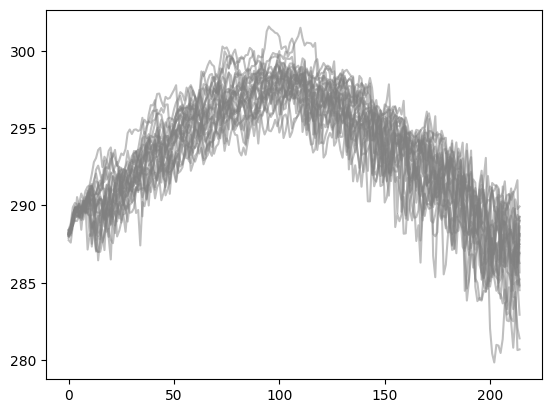

In [132]:
for i in range(num_members):
    # Select the subset of data for the current number
    subset = subset_hind_diff.sel(number=i)
    
    # Plotting
    plt.plot(subset, color='gray', alpha=0.5, label=f'Number {i}')